## Functions

In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors, rdMolDescriptors
from rdkit.Chem import Draw

from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.rdchem import Mol

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

import pandas as pd
import numpy as np

In [2]:
# def predict_products(substrate_smiles, smirks_pattern):
#     try:
#         # Convert the substrate SMILES to a molecule object
#         substrate_mol = Chem.MolFromSmiles(substrate_smiles)
        
#         # Check if conversion was successful; if not, return "NA"
#         if substrate_mol is None:
#             return np.nan
        
#         # Create a reaction object from the SMIRKS pattern
#         reaction = AllChem.ReactionFromSmarts(smirks_pattern)
        
#         # Apply the reaction to the substrate molecule
#         products_sets = reaction.RunReactants((substrate_mol,))
        
#         # If no products are generated, return "NA"
#         if not products_sets:
#             return np.nan
        
#         # Initialize a set to store unique product SMILES
#         unique_products_smiles = set()
        
#         # Iterate through the product sets and convert each product to a SMILES string
#         for product_set in products_sets:
#             for product in product_set:
#                 # Canonicalize the SMILES and add to the set to ensure uniqueness
#                 product_smiles = Chem.MolToSmiles(product, isomericSmiles=True)
#                 unique_products_smiles.add(product_smiles)
        
#         # If no unique products were added, return "NA"
#         if not unique_products_smiles:
#             return np.nan
        
#         # Convert the set to a list and return
#         return list(unique_products_smiles)
    
#     except Exception as e:
#         # If any error occurs, return "NA"
#         return np.nan
def predict_products(substrate_smiles, smirks_pattern):
    try:
        # Convert the substrate SMILES to a molecule object
        substrate_mol = Chem.MolFromSmiles(substrate_smiles)
        
        # Check if conversion was successful; if not, return an empty list
        if substrate_mol is None:
            return []
        
        # Create a reaction object from the SMIRKS pattern
        reaction = AllChem.ReactionFromSmarts(smirks_pattern)
        
        # Apply the reaction to the substrate molecule
        products_sets = reaction.RunReactants((substrate_mol,))
        
        # If no products are generated, return an empty list
        if not products_sets:
            return []
        
        # Initialize a set to store unique product SMILES
        unique_products_smiles = set()
        
        # Iterate through the product sets and convert each product to a SMILES string
        for product_set in products_sets:
            for product in product_set:
                # Canonicalize the SMILES and add to the set to ensure uniqueness
                product_smiles = Chem.MolToSmiles(product, isomericSmiles=True)
                unique_products_smiles.add(product_smiles)
        
        # If no unique products were added, return an empty list
        if not unique_products_smiles:
            return []
        
        # Convert the set to a list and return
        return list(unique_products_smiles)
    
    except Exception as e:
        # If any error occurs, return an empty list
        return []

# Note: For this code to work, RDKit library (`Chem` module from `rdkit`) needs to be installed and imported.
# This is just an illustrative example and will not be executed here directly.


In [3]:
def filter_by_mass_difference(product_smiles, substrate_smiles, mass_difference):
    """
    Filters a list of product molecules based on their monoisotopic mass difference relative to a substrate molecule, 
    both represented as SMILES strings. 
    Products are filtered to either those with the minimum positive mass difference (mass_difference = '+') 
    or those with the maximum negative mass difference (mass_difference = '-') from the substrate. 
    Invalid SMILES are ignored.

    Args:
    product_smiles (list of str): List of SMILES strings for product molecules.
    substrate_smiles (str): SMILES string for the substrate molecule.
    mass_difference (str): Specifies the direction of mass difference to filter by ('+' for positive, '-' for negative).

    Returns:
    list of str: SMILES strings of products matching the specified mass difference criteria.

    Raises:
    ValueError: If substrate SMILES is invalid or mass_difference is not '+' or '-'"
    """
    try:
        # Convert substrate SMILES to molecule and calculate its monoisotopic mass
        substrate_mol = Chem.MolFromSmiles(substrate_smiles)
        if substrate_mol is None:
            raise ValueError("Invalid substrate SMILES.")
        
        substrate_mass = Descriptors.ExactMolWt(substrate_mol)
        
        # Initialize a list to hold products and their masses
        product_masses = []
        
        # Iterate through the product SMILES
        for smi in product_smiles:
            # Convert product SMILES to molecule and calculate its monoisotopic mass
            product_mol = Chem.MolFromSmiles(smi)
            if product_mol is None:
                continue  # Skip invalid product SMILES
                
            product_mass = Descriptors.ExactMolWt(product_mol)
            mass_diff = product_mass - substrate_mass
            
            # Store product masses and SMILES
            if (mass_difference == '+' and mass_diff > 0) or (mass_difference == '-' and mass_diff < 0):
                product_masses.append((mass_diff, smi))
        
        # Filter based on mass_difference criteria
        if mass_difference == '+':
            # Find the minimum positive mass difference
            min_mass_diff = min([x[0] for x in product_masses] or [0])
            # Filter products with the minimum mass difference
            matching_products = [smi for diff, smi in product_masses if diff == min_mass_diff]
        elif mass_difference == '-':
            # Find the maximum negative mass difference
            max_mass_diff = max([x[0] for x in product_masses] or [0])
            # Filter products with the maximum mass difference
            matching_products = [smi for diff, smi in product_masses if diff == max_mass_diff]
        else:
            # If mass_difference is not '+' or '-', return an empty list (or handle as needed)
            raise ValueError("Invalid mass_difference value. Use '+' or '-'.")
        
        return matching_products
    
    except Exception as e:
        # Handle exceptions, possibly logging them or returning an error message
        print(f"An error occurred: {e}")  # Optionally log the error message
        return []

In [4]:
def find_sub_structure(smiles, smarts):
    """
    This function finds and highlights the substructure in a molecule defined by a SMARTS pattern.

    Parameters:
    - smiles (str): The SMILES representation of the molecule.
    - smarts (str): The SMARTS pattern to search for within the molecule.

    Returns:
    - An image of the molecule with the matching substructure highlighted, if any matches are found.
    """
    # Convert the SMILES string to an RDKit molecule object
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return "Invalid SMILES string."

    # Convert the SMARTS string to an RDKit molecule object
    query = Chem.MolFromSmarts(smarts)
    if not query:
        return "Invalid SMARTS pattern."

    # Find the atoms in the molecule that match the SMARTS pattern
    matches = mol.GetSubstructMatches(query, uniquify=False)

    print(matches)
    img = Draw.MolToImage(mol, highlightAtoms=sum(matches, ()), subImgSize=(500, 500))
    return img

In [5]:
def smarts_to_formula(smarts):
    # Convert the SMARTS string to a molecule object
    molecule = Chem.MolFromSmarts(smarts)
    if molecule is None:
        return "Invalid SMARTS string"
    try:
        # Attempt to sanitize the molecule to ensure properties can be calculated
        Chem.SanitizeMol(molecule)
        # Calculate the molecular formula
        formula = rdMolDescriptors.CalcMolFormula(molecule)
        return formula + ' (ignore H)'
    except Exception as e:
        return f"Error processing molecule: {str(e)}"

In [6]:
# Plot a pipe: substract -> reaction group -> product
# usage: plot_reaction_scheme(substrate, product, smarts)

# def find_sub_structure(substrate, smarts):
#     try:
#         substructure = substrate.GetSubstructMatch(Chem.MolFromSmarts(smarts))
#         if substructure:
#             img = Draw.MolToImage(substrate, highlightAtoms=substructure, size=(300, 300))
#             return img
#         else:
#             raise ValueError("Substructure matching failed.")
#     except Exception as e:
#         # If anything goes wrong, return a placeholder image with "Missing"
#         img = Image.new('RGB', (300, 300), color = (255, 255, 255))
#         d = ImageDraw.Draw(img)
#         d.text((10,10), "Missing", fill=(0,0,0))
#         return img

def plot_reaction_scheme(substrate_smiles, product_smiles, smarts_pattern):
    try:
        # Create RDKit molecule objects
        mol_substrate = Chem.MolFromSmiles(substrate_smiles)
        mol_product = Chem.MolFromSmiles(product_smiles)

        # Generate images for the substrate and product
        substrate_img = Draw.MolToImage(mol_substrate, size=(300, 300))
        product_img = Draw.MolToImage(mol_product, size=(300, 300))

        # Find and generate the sub-structure image
        sub_structure_img = find_sub_structure(mol_substrate, smarts_pattern)
    except Exception as e:
        print(f"Error processing molecules: {e}")
        return

    # Create a figure and axes with 1 row and 5 columns
    fig, ax = plt.subplots(1, 5, figsize=(15, 3))

    # Plotting substrate
    try:
        ax[0].imshow(substrate_img)
    except Exception:
        ax[0].text(0.5, 0.5, 'Missing', horizontalalignment='center', verticalalignment='center')
    ax[0].axis("off")

    # First arrow
    ax[1].text(0.5, 0.5, '→', horizontalalignment='center', verticalalignment='center', fontsize=30, color="darkgrey")
    ax[1].axis("off")

    # Plotting sub-structure
    try:
        ax[2].imshow(sub_structure_img)
    except Exception:
        ax[2].text(0.5, 0.5, 'Missing', horizontalalignment='center', verticalalignment='center')
    ax[2].axis("off")

    # Second arrow
    ax[3].text(0.5, 0.5, '→', horizontalalignment='center', verticalalignment='center', fontsize=30, color="darkgrey")
    ax[3].axis("off")

    # Plotting product
    try:
        ax[4].imshow(product_img)
    except Exception:
        ax[4].text(0.5, 0.5, 'Missing', horizontalalignment='center', verticalalignment='center')
    ax[4].axis("off")

    plt.tight_layout()
    plt.show()

In [7]:
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
from PIL import Image, ImageDraw
import io

def find_sub_structure(smiles, smarts):
    """
    Finds and highlights the substructure in a molecule defined by a SMARTS pattern.
    """
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return "Invalid SMILES string."

    query = Chem.MolFromSmarts(smarts)
    if not query:
        return "Invalid SMARTS pattern."

    matches = mol.GetSubstructMatches(query, uniquify=True)
    if not matches:
        return None  # Adjusted to return None for no matches

    img = Draw.MolToImage(mol, highlightAtoms=sum(matches, ()), size=(300, 300))
    return img

def plot_reaction_scheme(substrate_smiles, product_smiles, smarts_pattern):
    """
    Plots a reaction scheme showing the substrate, sub-structure, and product.
    """
    try:
        mol_substrate = Chem.MolFromSmiles(substrate_smiles)
        substrate_img = Draw.MolToImage(mol_substrate, size=(300, 300))
    except Exception as e:
        substrate_img = "Error"

    try:
        mol_product = Chem.MolFromSmiles(product_smiles)
        product_img = Draw.MolToImage(mol_product, size=(300, 300))
    except Exception as e:
        product_img = "Error"

    # Use the provided find_sub_structure function
    sub_structure_img = find_sub_structure(substrate_smiles, smarts_pattern)
    if isinstance(sub_structure_img, str):  # Check if the function returned an error message
        sub_structure_img = "Error"

    # Create a figure and axes with 1 row and 5 columns
    fig, ax = plt.subplots(1, 5, figsize=(15, 3))

    # Helper function to plot images or placeholders
    def plot_image_or_placeholder(ax, img, placeholder_text="Missing"):
        if img == "Error":
            ax.text(0.5, 0.5, placeholder_text, horizontalalignment='center', verticalalignment='center', fontsize=12)
            ax.axis("off")
        else:
            ax.imshow(img)
            ax.axis("off")

    # Plotting substrate
    plot_image_or_placeholder(ax[0], substrate_img)

    # First arrow
    ax[1].text(0.5, 0.5, '→', horizontalalignment='center', verticalalignment='center', fontsize=30, color="royalblue")
    ax[1].axis("off")

    # Plotting sub-structure
    plot_image_or_placeholder(ax[2], sub_structure_img, "No Match")

    # Second arrow
    ax[3].text(0.5, 0.5, '→', horizontalalignment='center', verticalalignment='center', fontsize=30, color="royalblue")
    ax[3].axis("off")

    # Plotting product
    plot_image_or_placeholder(ax[4], product_img)

    plt.tight_layout()
    plt.show()

## Input

In [50]:
substrate = 'Cc1ccccc1C(=O)O'
smirks = '[*:1]-C(=O)O>>[*:1]-O'
mass_difference = '-'

substrate = 'C1-CC(=CN=C1)C(=O)S'
smirks = '[n:1]1ccccc1>>[n+:1]1(c2c(O)c(O)c(CO)o2)ccccc1'
substrate = 'CS(SCNC1-C-NC2=C1NC=N2)CS'
# smirks = '[nH1:1]1ccnc1>>[n:1](c2c(O)c(O)c(CO)o2)1ccnc1'
smirks = '[nH1:1]1c2cncnc2nc1>>[n:1]1(c3c(O)c(O)c(CO)o3)c2cncnc2nc1'

mass_difference = '+'

### Input compounds

264.053709512


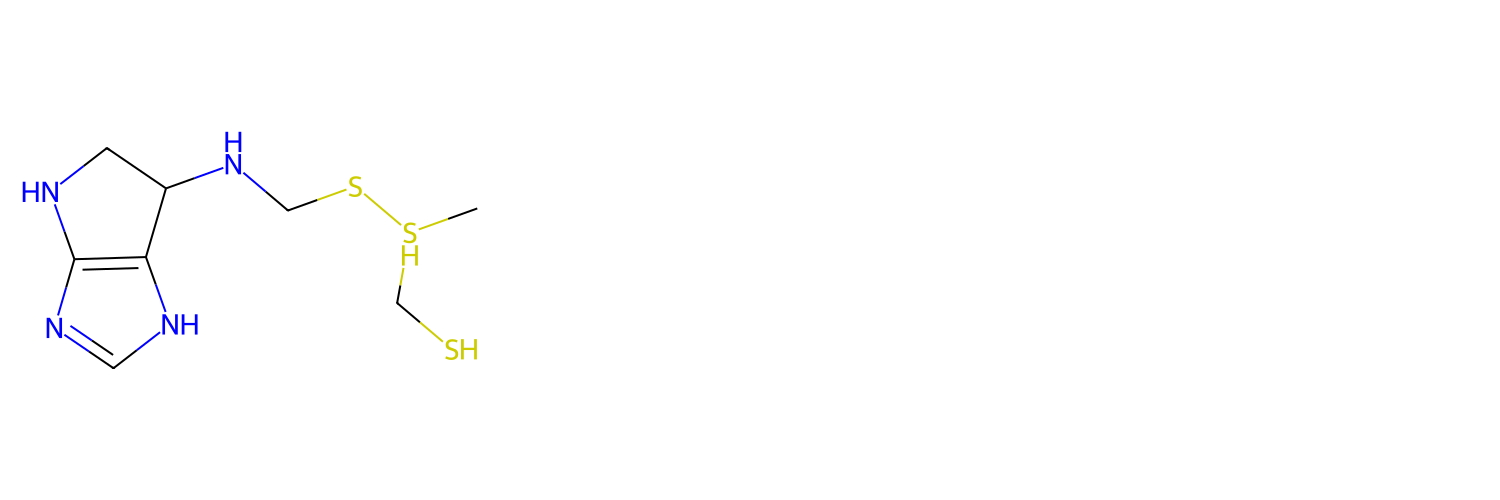

In [51]:
mol_substrate = Chem.MolFromSmiles(substrate)
print(Descriptors.ExactMolWt(mol_substrate))
fig = Draw.MolsToGridImage([mol_substrate], subImgSize=(500, 500))
fig

### Substracture

120.04359612799999
Error processing molecule: Kekulization somehow screwed up valence on 0: 0!=1



[16:14:35] Kekulization somehow screwed up valence on 0: 0!=1



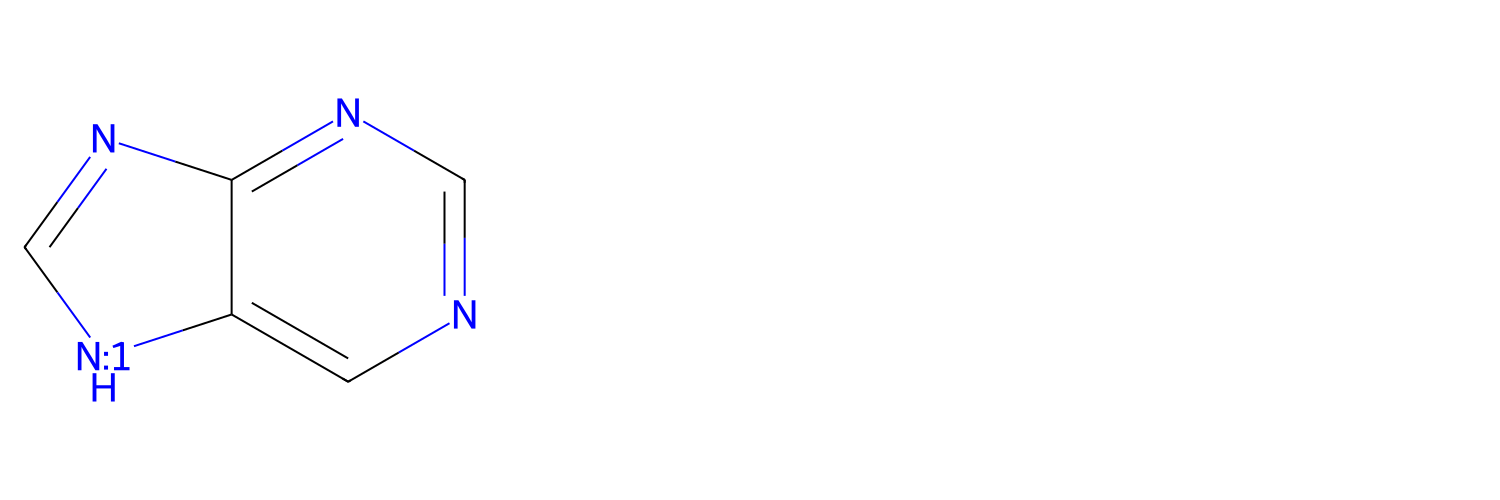

In [52]:
smarts = smirks.split('>>')[0]
mol_substrate = Chem.MolFromSmiles(smarts)
print(Descriptors.ExactMolWt(mol_substrate))
print(smarts_to_formula(smarts))
fig = Draw.MolsToGridImage([mol_substrate], subImgSize=(500, 500))  # Adjust (300, 300) as needed
fig

In [53]:
find_sub_structure(substrate, smarts)

### Rxn pattern

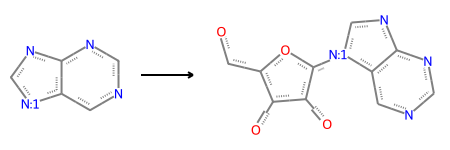

In [54]:
rxn = AllChem.ReactionFromSmarts(smirks)
rxn

## Pred

In [55]:
products = predict_products(substrate, smirks)
print('All the Products:')
print()
if products != 'NA':
    for p in products:
        print(p)

All the Products:



## Result

In [56]:
product = filter_by_mass_difference(products, substrate, mass_difference)
print(product)
product = product[0]

[]


IndexError: list index out of range

In [57]:
process = substrate + '>>' + product
process

TypeError: can only concatenate str (not "list") to str

In [58]:
mol_substrate = Chem.MolFromSmiles(product)
print(Descriptors.ExactMolWt(mol_substrate))
fig = Draw.MolsToGridImage([mol_substrate], subImgSize=(500, 500))  # Adjust (300, 300) as needed
fig

TypeError: No registered converter was able to produce a C++ rvalue of type std::__1::basic_string<wchar_t, std::__1::char_traits<wchar_t>, std::__1::allocator<wchar_t>> from this Python object of type list

TypeError: Image data of dtype object cannot be converted to float

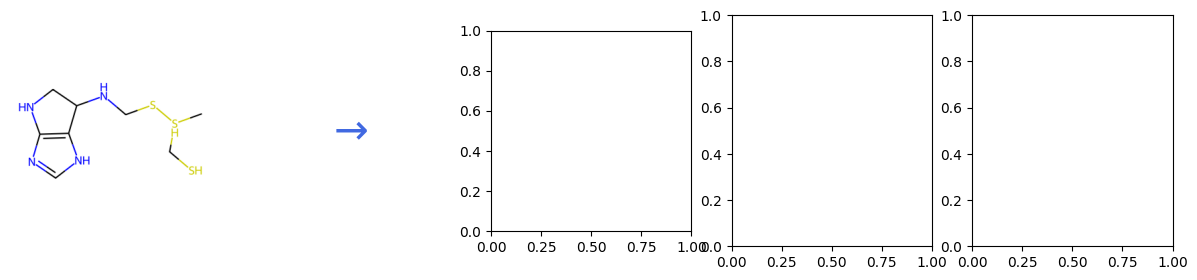

In [59]:
plot_reaction_scheme(substrate, product, smarts)

************************************

# TEST PART

In [220]:
ref = pd.read_csv('/Users/bowen/Desktop/MCID2.0/03_initial_result/01_kegg/1_rxn/mcidxkegg_1811882_all.csv')
ref = ref[['possible_reaction','smiles','substrate_name_all']]

In [142]:
trimming_ref = ref[ref['possible_reaction'] == 'R60']
trimming_ref.index = range(1, len(trimming_ref)+1)
trimming_ref.head(30)

,possible_reaction,smiles,substrate_name_all
1,R60,O=C1N=C(N)C=CN1C2OC(COC3C(O)C(OC3COP(=O)(O)OP(...,ATP;_Adenosine 5'-triphosphate
2,R60,O=C1N=C(N)C=CN1C2OC(CO)C(OC3C(O)C(OC3COP(=O)(O...,ATP;_Adenosine 5'-triphosphate
3,R60,O=C1N=C(N)C=CN1C2OC(CO)C(OC3C(O)C(OC3N4C=NC=5C...,ATP;_Adenosine 5'-triphosphate
4,R60,O=C1N=C(N)C=CN1C2OC(COC3C(O)C(OC3N4C=NC=5C(=NC...,ATP;_Adenosine 5'-triphosphate
5,R60,O=C1N=C(N)C=CN1C2OC(COC3C(O)C(OC3[N+]=4C=CC=C(...,NAD+;_NAD;_Nicotinamide adenine dinucleotide;_...
6,R60,O=C1N=C(N)C=CN1C2OC(COC3C(O)C(OC3COP(=O)(O)OP(...,NAD+;_NAD;_Nicotinamide adenine dinucleotide;_...
7,R60,O=C1N=C(N)C=CN1C2OC(COC3C(O)C(OC3COP(=O)(O)OP(...,NAD+;_NAD;_Nicotinamide adenine dinucleotide;_...
8,R60,O=C1N=C(N)C=CN1C2OC(CO)C(OC3C(O)C(OC3[N+]=4C=C...,NAD+;_NAD;_Nicotinamide adenine dinucleotide;_...
9,R60,O=C1N=C(N)C=CN1C2OC(COC3C(O)C(OC3N4C=NC=5C(=NC...,NAD+;_NAD;_Nicotinamide adenine dinucleotide;_...
10,R60,O=C1N=C(N)C=CN1C2OC(CO)C(OC3C(O)C(OC3COP(=O)(O...,NAD+;_NAD;_Nicotinamide adenine dinucleotide;_...


In [143]:
line_at_index = trimming_ref.loc[1]
print(line_at_index)
print(line_at_index['smiles'])

possible_reaction                                                   R60
smiles                O=C1N=C(N)C=CN1C2OC(COC3C(O)C(OC3COP(=O)(O)OP(...
substrate_name_all                       ATP;_Adenosine 5'-triphosphate
Name: 1, dtype: object
O=C1N=C(N)C=CN1C2OC(COC3C(O)C(OC3COP(=O)(O)OP(=O)(O)OP(=O)(O)O)N4C=NC=5C(=NC=NC54)N)C(O)C2O


260.02971862600003


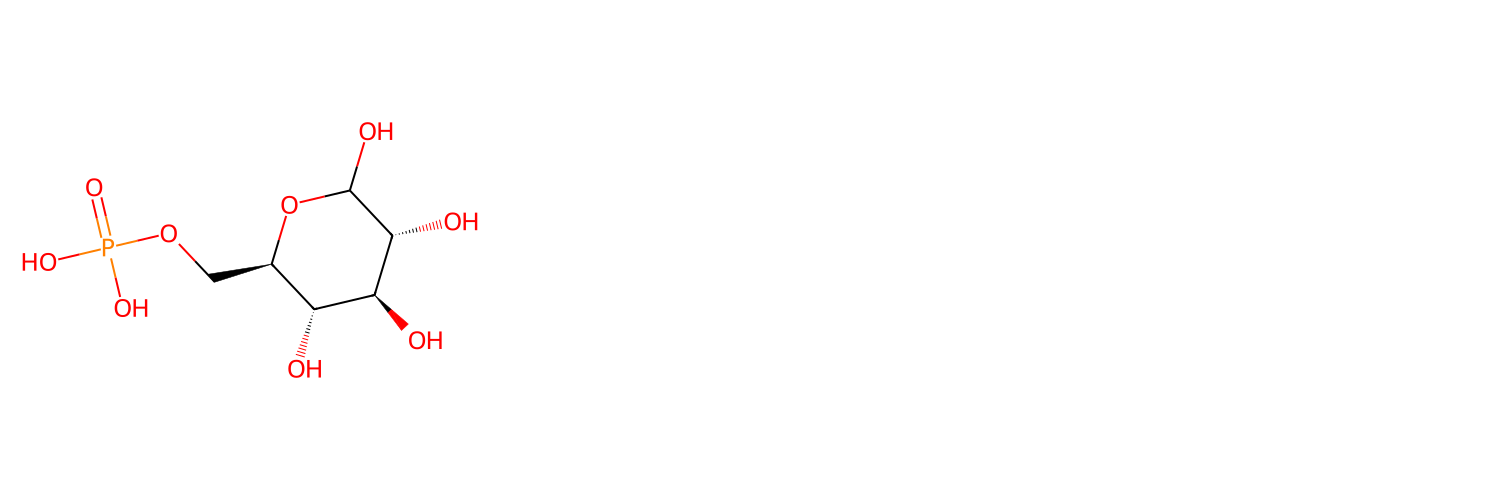

In [26]:
mol_substrate = Chem.MolFromSmiles('O=P(O)(O)OC[C@H]1OC(O)[C@H](O)[C@@H](O)[C@@H]1O')
print(Descriptors.ExactMolWt(mol_substrate))
# Chem.Draw.MolsToGridImage([mol_substrate])
fig = Draw.MolsToGridImage([mol_substrate], subImgSize=(500, 500)) 
fig

In [54]:
663.1091218040001 - 635.1142071840001

27.99491462000003

# 2. Some Rxn hard to use SMIRKS to represent

In [345]:
def predict_products_group(substrate, subgroup, smirks):
    mol = Chem.MolFromSmiles(substrate)
    pattern = Chem.MolFromSmarts(subgroup)
    matches = mol.GetSubstructMatches(pattern)
    modified_molecules = []

    reaction = AllChem.ReactionFromSmarts(smirks)

    for match in matches:
        # Apply the reaction to the molecule. The reaction expects a list of reactants, but we have only one.
        products = reaction.RunReactants((mol,))

        # Assuming the reaction produces at least one product, take the first product.
        if products:
            product_mol = products[0][0]  # Take the first product
            modified_smiles = Chem.MolToSmiles(product_mol, isomericSmiles=True)
            modified_molecules.append(modified_smiles)

    return modified_molecules

# Example usage
substrate = 'CCCCOC1=CC2=NC3=CC=CC=C3N=C2C=C1'  # Example molecule with an OH group to be replaced
subgroup = 'c1nccnc1'  # Target OH group on a ring
smirks = '[C:1]=[N:2]>>[C:1]-[N:2]'  # Reaction: Replace OH with sulfate group

product = predict_products_group(substrate, subgroup, smirks)
print(product)

[]


[15:48:10] SMILES Parse Error: syntax error while parsing: [C:1]=[N:2]>>[C:1]-[N:2]
[15:48:10] SMILES Parse Error: Failed parsing SMILES '[C:1]=[N:2]>>[C:1]-[N:2]' for input: '[C:1]=[N:2]>>[C:1]-[N:2]'


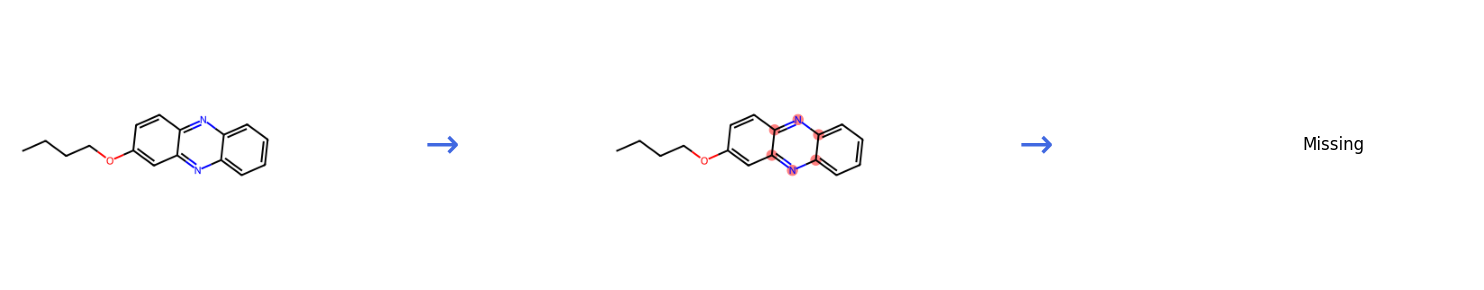

In [346]:
plot_reaction_scheme(substrate, smirks, subgroup)

### Convert SMILES to InChIKey

In [65]:
from rdkit import Chem
from rdkit.Chem import inchi

def smiles_to_inchikey(smiles):
    # Create an RDKit molecule object from the SMILES string
    mol = Chem.MolFromSmiles(smiles)
    
    # Ensure the molecule was correctly created
    if mol is None:
        return None, "Invalid SMILES string"
    
    # Convert the molecule to InChI
    inchi_str = inchi.MolToInchi(mol)
    
    # Convert the InChI to InChIKey
    inchi_key = inchi.InchiToInchiKey(inchi_str)
    
    return inchi_key

# Example usage
smiles_string = "NC(CCC(=O)NC(CS)C(=O)NCC(=O)O)C(=O)O" 
inchi_key = smiles_to_inchikey(smiles_string)
print(f"InChIKey: {inchi_key}")

InChIKey: RWSXRVCMGQZWBV-UHFFFAOYSA-N


[00:06:12] WARNING: Omitted undefined stereo



### Find sub-group

Found 1 match(es).
Atoms in match: (15, 14, 7, 6, 5, 4, 0, 1, 2, 3, 17, 19, 12, 11, 10, 8, 9, 13)


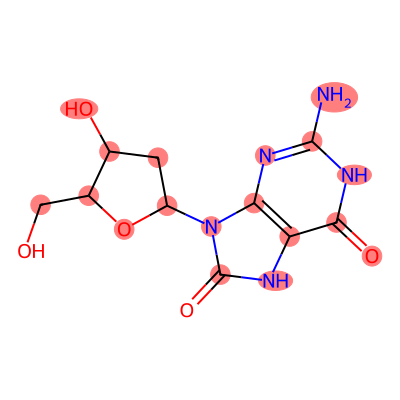

In [57]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D  # Correct import for drawing utilities
from IPython.display import SVG  # Import SVG for displaying inline in Jupyter

def find_subgroups(substrate_smiles, subgroup_smiles):
    """
    Finds all instances of a specified subgroup in a substrate and highlights them in the original molecule.
    
    Parameters:
    - substrate_smiles (str): SMILES string of the substrate molecule.
    - subgroup_smiles (str): SMILES string of the subgroup to be found.
    
    Returns:
    - list: List of indices of atoms in each found subgroup.
    - Visualization: Shows the original molecule with highlighted subgroups.
    """
    substrate = Chem.MolFromSmiles(substrate_smiles)
    subgroup = Chem.MolFromSmiles(subgroup_smiles)
    
    matches = substrate.GetSubstructMatches(subgroup, uniquify=True)
    if not matches:
        print("No matches found.")
        return []
    
    # Highlight the matching subgroups in the substrate molecule
    print(f"Found {len(matches)} match(es).")
    for match in matches:
        print("Atoms in match:", match)
    
    # Visualization part: highlight subgroups in the original molecule
    d = rdMolDraw2D.MolDraw2DSVG(400, 400)
    rdMolDraw2D.PrepareAndDrawMolecule(d, substrate, highlightAtoms=sum(matches, ()))
    d.FinishDrawing()
    display(SVG(d.GetDrawingText()))

    return matches  # Returning the list of matches (atom indices in each match)

# Example usage
substrate_smiles = "C1C(C(OC1N2C3=C(C(=O)NC(=N3)N)NC2=O)CO)O"
subgroup_smiles = "c1nc2c(n1[C@H]3C[C@@H]([C@H](O3)C)O)[nH]c(nc2=O)N"  # Phosphate group to replace
replacement_smiles = None
matches = find_subgroups(substrate_smiles, subgroup_smiles)

***************

In [58]:
def drop_group(substrate, subgroup, replacement_group=None):
    substrate_mol = Chem.MolFromSmiles(substrate)
    subgroup_mol = Chem.MolFromSmiles(subgroup)
    replacement_mol = Chem.MolFromSmiles(replacement_group) if replacement_group else None
    
    matches = substrate_mol.GetSubstructMatches(subgroup_mol, uniquify=True)
    modified_molecules = set()

    for match in matches:
        editable_mol = Chem.RWMol(Chem.Mol(substrate_mol))
        
        # Collect atoms to remove and check ring status
        atoms_to_remove = []
        ring_atoms_to_modify = []  # List to keep track of ring atoms
        for atom_idx in match:
            atom = editable_mol.GetAtomWithIdx(atom_idx)
            for neighbor in atom.GetNeighbors():
                if neighbor.GetIdx() not in match:
                    if neighbor.IsInRing():
                        ring_atoms_to_modify.append(neighbor.GetIdx())
                    break
            else:
                atoms_to_remove.append(atom_idx)
        
        # Remove specified atoms
        for atom_idx in sorted(atoms_to_remove, reverse=True):
            editable_mol.RemoveAtom(atom_idx)
        
        # If a replacement molecule is provided, handle its addition here
        # Note: The logic for adding a replacement group, especially with bond creation, might need to be adjusted 
        # based on the specific requirements and chemical validity.

        # After removal and optional replacement, iterate over ring atoms to modify
        # Since directly changing SMILES characters is not straightforward, consider adjusting atom properties or annotations
        # to indicate modifications or special conditions for ring atoms.
        # Direct manipulation of the SMILES string to change characters to uppercase is not chemically meaningful
        # and not supported by RDKit directly.

        modified_molecule = editable_mol.GetMol()  # Finalize modifications
        
        modified_smiles = Chem.MolToSmiles(modified_molecule, isomericSmiles=True)
        modified_molecules.add(modified_smiles)
    
    if not modified_molecules:
        return [substrate]  # Return the original if no modifications were made
    
    return list(modified_molecules)



substrate = "C1C(C(OC1N2C=NC3=C(N=CN=C32)N)COP(=O)(O)O)O"
subgroup = 'C1C(C(OC1N2C=NC3=C(N=CN=C32)N)CO)O'
replacement_group = None

products_smiles = drop_group(substrate, subgroup, replacement_group)

In [59]:
products_smiles

['O=P(O)(O)O']

In [60]:
def check_smiles_availability(smiles_list):
    """
    For available SMILES in the list, keep them.
    For unavailable SMILES, change all the characters to uppercase and check again.
    If the uppercase version is available, keep it. Otherwise, drop it.

    :param smiles_list: List of SMILES strings
    :return: List of available SMILES strings after processing
    """
    # Placeholder function to simulate checking the availability of a SMILES string
    def is_available(smiles):
        # Replace this with actual logic to check SMILES availability in a database
        # For demonstration, let's pretend all lowercase SMILES are unavailable
        return smiles.isupper()
    
    available_smiles = []
    for smiles in smiles_list:
        # Check if the SMILES is available
        if is_available(smiles):
            available_smiles.append(smiles)
        else:
            # If not available, convert to uppercase and check again
            smiles_upper = smiles.upper()
            if is_available(smiles_upper):
                available_smiles.append(smiles_upper)
            # If still not available, it is dropped
    
    return available_smiles

In [60]:
import pandas as pd

def process_substrate_df(substrate_df, rxn_rules_df):
    # Container for the resulting DataFrames
    results = []

    # Loop through each row in the substrate DataFrame
    for index, row in substrate_df.iterrows():
        substrate = row['SMILES']
        substrate_name = row['Name']

        # Call the pipeline function
        result_df = pipeline_function(substrate, rxn_rules_df)

        if result_df is not None:
            # Add the Substrate_Name column
            result_df['Substrate_Name'] = substrate_name
            results.append(result_df)

    # Concatenate all results into one DataFrame if there are any results
    if results:
        final_df = pd.concat(results, ignore_index=True)
        return final_df
    else:
        return pd.DataFrame()  # Return an empty DataFrame if no results

Uncomment the line below to use the function with example parameters
process_substrate_df(pd.DataFrame('pipeline/output.csv', 'rxn_rules_example')

SyntaxError: invalid syntax (859616481.py, line 27)